# 1. Control Systems

In this course we will study how sensorimotor systems in the brain learn to control the body. The mathematical
principles of learning and control have become clearer in recent years thanks to research in artificial intelligence and robotics, so we will borrow concepts from these disciplines to help us understand the brain, and conversely, we will consider how ideas from neuroscience may benefit artificial systems.



In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np

## State Dynamics

Any sensorimotor task starts with an agent of some sort 
embedded in an environment. We write $s_{t}$ for the _state_
of the environment at time $t$, and $a_{t}$ for the agent’s _action_ at this time (where both $s_{t}$ and $a_{t}$ are column vectors).

For example, the agent might be the saccadic system in the brain, which rotates the eyes quickly to aim them at 
an object of interest. In that case $s_{t}$ might include the current positions of the eyes and the location of the visual target. And $a_{t}$ might be the motor command — the firing rates of the motoneurons to the muscles that move the eyes.

In this course, we assume that time passes in discrete steps of some fixed size $\Delta t $, because that approach is 
convenient for computer simulations. With each step, the state takes a new value:

$(1)$
 $$  s_{t-1}=f(s_{t},a_{t})$$
 

where $f$ is called the _state-dynamics function_.

## Simulating dynamics
In our equations, time passes in discrete steps. But real time is continuous, and real processes obey _differential_ equations, such as $\frac{ds}{dt} = g(s, a)$. We can approximate such systems in our discrete-time framework using Euler integration, where we say

$(2)$
$$s_{t+\Delta t}= f(s_{t},a_{t}) = s_{t} + \Delta s_{t} = s_{t} + \Delta t \frac{ds}{dt} (s_{t},a_{t})$$

In other words, we compute $\frac{ds}{dt}$ at time $t$ and pretend that the velocity stays constant over the whole time interval $[t,t+\Delta t)$.This approximation will usually be more accurate when $\Delta t$ is smaller, but small $\Delta t$’s are computationally expensive, because it takes a lot of them to cover, say, 1 s of time. In this course, a good compromise will be to choose $\Delta t$ in the range $0.1$ to 
$0.001$ seconds.

We will call $\frac{\Delta s_{t}}{\Delta t}$ the _discrete-time velocity_ of $s$.


### Euler Integration Code

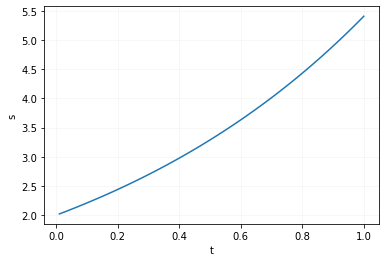

In [2]:
# Euler's method of numerical integration for the differential equation
# ds/dt = s

# Set simulation parameters & initialize system
dur = 1.0  # duration of simulated process in seconds
Dt = 0.01  # time step for simulation
t = 0.0  # initial time
s = 2.0  #initial state

time = [] #Storing Time to graph
state =[] #Storing State to graph

t = Dt

for i in range(int(dur/Dt)): #start at t = Dt; take steps of size Dt; end at t = dur
    
    s_vel = s
    s = s + Dt*s_vel #Euler integration
    time.append(t)
    state.append(s)
    t += Dt

plt.plot(time,state)
plt.ylabel('s')
plt.xlabel('t')
plt.grid(linestyle='-',linewidth=0.5,color='#f1f1f1')
plt.show()

    


## Policy

The agent’s job is to choose actions, $a$, that achieve its aims, given the rules laid out by the state dynamics. In this course we will usually assume that the agent, based on its sensory inputs, memories, and intentions, knows $s_{t}$ in full at every time $t$.That is, we consider situations where _state feedback_ is available, not ones where the state is only partially observable.


The rule the agent uses to compute $a$’s from $s$’s is called its _policy_, $\mu$.

$(3)$
$$a_{t} = \mu(s_{t})$$

A policy may be stochastic, e.g. it may choose its action $a_{t}$ by computing some deterministic function of $s_{t}$ and then adding _Gaussian noise_, i.e. a random variable with a Gaussian, or _normal_, distribution.

## Rewards

An agent needs a policy that will achieve its aims, but what are these aims? We assume the agent receives or computes, $a_{t}$ each time step, a signal called a _reward_, $r_{t}$, usually determined by the current state and action,

$(4)$
$$r_{t} = r(s_{t},a_{t})$$

The reward function defines what the agent wants. A high reward indicates something the agent finds pleasant, which might be light, or dark, or heat, or cold, or some food, or having some visual target perfectly centred on the fovea, whereas a lower reward is less pleasant.


The reward at any moment is a scalar: it may be computed from the vectors $s_{t}$ and $a_{t}$, but it expresses the overall pleasantness of the situation in a single number. The agent’s job is to choose actions that yield high rewards.

For example, suppose the agent wants to hold s near a target state $s = 0$. We can express that wish mathematically by defining a reward that is maximal when $s = 0$, and is otherwise much lower, such as


$(5)$
$$r_{t}(s_{t},a_{t}) = - tanh(s_{t}   ^{T}  s_{t})$$

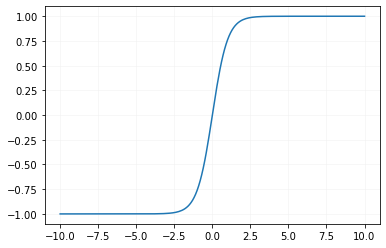

In [3]:
#Graph the tanh graph

x=[]
y=[]
i=-10
while (i<=10):
    x.append(i)
    y.append(math.tanh(i))
    i=i+0.1
    
plt.plot(x,y)
plt.grid(linestyle='-',linewidth=0.5,color='#f1f1f1')


plt.show()

This $r_{t}$ attains its maximum, namely $0$, when $s$ equals its target value of $0$. But if $s$ is even a little off target then $r_{t}$ is close to its minimum of $–1$. It may seem odd that the reward $(5)$ is defined with a negative sign and has a maximal value of $0$ — i.e. the best reward we can ever get is nothing. But rewards of this type are common in sensorimotor systems, many of which try to eliminate some bad thing, such as being off-target, and their highest reward is to zero that bad thing. Equation $(5)$ also shows that $r_{t}$ doesn’t always depend on  both $s_{t}$ and $a_{t}$, but I have written $r(s_{t}, a_{t})$ nonetheless because in general, rewards do depend on both.

## Returns

I have introduced the idea of rewards as a step toward expressing an agent’s aims mathematically, but many practical aims can’t be defined simply in terms of maximizing a reward at each moment. Instead, most purposive behaviour aims to maximize the _time-integral_ of a reward, called the _return_, which (for some reason) is usually represented by a letter $G$ in formulas.

For example, suppose we want to drive a mechanical system such as an arm or leg to a target state as quickly as possible and hold it there — a task called time-optimal control. If the target state is $0$ then $(5)$ is an apt reward function, but we should not aim to maximize this reward at each moment. If we do, we will drive $s$ to $0$ at high speed, so as to raise $r_{t}$ quickly, but then we may have so much momentum that we overshoot the target, and $r_{t}$ plummets. Essentially, if we maximize $r_{t}$ at each moment then we won’t hit the brakes in a timely fashion. Policies of this type, which maximize immediate reward at each instant with no regard for future consequences, are called myopic.

We don’t want a myopic policy that maximizes immediate reward, we want a policy that cares about the future, and so tries to maximize the discrete-time integral of the reward from the present moment, $t = 0$, to some future time $T$, 


$(6)$
$$G = \Delta t \sum_{t=0...T} r_{t}$$

where $T$ may be $\infty$. This integral formulation expresses the aim of time-optimal control, because clearly the way to maximize $G$ is to get $s$ to $0$ as quickly as possible without overshooting.

## Vestibulo-ocular reflex

An example of a sensorimotor system is the _vestibuloocular reflex_, or VOR, which senses head motion and counterrotates the eyes to keep the retinal images stable. Without your VOR, your vision would blur whenever you moved, like a photo taken with a moving camera.

For simplicity we will consider just one eye, rotating only horizontally, in which case the state $s_{t}$ consists of horizontal eye position $q_{t}$ and current horizontal head velocity $h_{t}$, the latter measured by sensors called semicircular canals located in the inner ears, in cavities in the skull bones called the vestibula. We write,

$(7)$
$$s_{t} = [q_{t};h_{t}]$$


where the semicolon means we stack $q_{t}$ and $h_{t}$ vertically, one on top of the other, to form a column vector $s_{t}$.

The variables $q_{t}$ and $h_{t}$ have just one element each, and 
so could be regarded as scalars (i.e. numbers), but we will view them as one-element vectors because in most systems, the position and input variables are vectorial.

Throughout the course, we will write $q$ for the _configuration_ of a system, i.e. its position, location, or posture, as opposed to its velocity, acceleration, etc. The elements of $q$ are the system’s degrees of freedom.

What are the state dynamics of the VOR? Eye position 
$q$ evolves (to a good approximation) this way:


$(8)$
$$q_{t+ \Delta t} = q_{t}+ \Delta q_{t} = q_{t} + \frac{\Delta t (a_{t} - \kappa q_{t})}{\rho}$$

Here κ and ρ are constants that reflect the mechanical properties — stiffness and viscosity — of the eye muscles. Realistic values are $ \kappa = 250$ and $\rho = 50$, if $t$ is measured in seconds, $q$ in radians, and a in mean spike rate per motoneuron per second. 

As for head velocity $h_{t}$, we will measure it in radians/s and treat it as something random, which the agent cannot predict, but must simply read in from its sensors in the inner ear. In reality you _can_ predict your head motion to some extent, as it is partly under your control,  but it may also be affected by unpredictable factors, as when you are riding a bucking bronco. For now, it is simpler to treat $h_{t}$ as completely unpredictable.

What are the aims of the VOR? It tries to _minimize_ the velocity with which the visual image is slipping across the retina, so we can define its reward as the _negative_ of the squared slip velocity,

$(9)$
$$ r_{t} = r(s_{t},a_{t}) = -||(\frac{\Delta q_{t}}{\Delta t})+h_{t}||^2$$

(though other choices, such as the negative of the nonsquared magnitude of the slip velocity, would also be reasonable).

The VOR’s policy is a neural network in the brainstem and cerebellum. It receives information about $s_{t}$ and uses it to compute an action $a_{t}$, which is another one-element vector, the mean firing of the motoneurons. (Or more precisely, it is the difference between the mean firing rates of the motoneurons to the rightward and leftward-pulling eye muscles.)

What is the best policy? Using (8), we see that $r_{t}$ can be 
maximized (that is, zeroed) if:

$(10)$
$$a_{t} = \mu(s_{t}) = \kappa q_{t} - \rho h_{t}$$

To apply this policy, the agent must know not just $s_{t}$ but also the stiffness and viscosity coefficients of the muscles, $\kappa$ and $\rho$. No sensory signals can report those values in any straightforward way, but by observing eye motions evoked by a wide variety of actions, $a$, the agent can gradually deduce them. In other words, the agent can learn estimates of $\kappa$ and $\rho$.

To emphasize that it uses approximations rather than exact, true values, we write the policy this way,


$(11)$
$$a_{t} = \mu (s_{t}) = <\kappa> q_{t} - <\rho> h_{t}$$

where corner brackets indicate estimates. In any system with estimates of environment properties, such as $<\kappa>$ and $<\rho>$, we call the set of estimates a model of the environment

### Vor Code

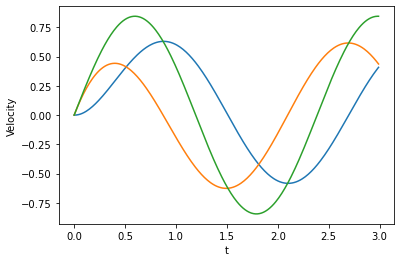

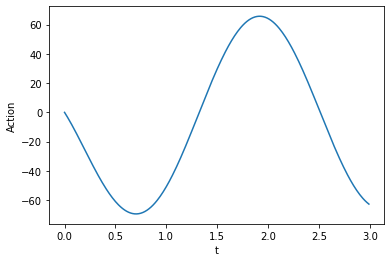

In [4]:
#Vestibulo-ocular reflex

#Setting the parameters:

rand = 0.1345
#np.random.uniform(low=0.0, high=1.0)

Dt = 0.01 #Time step in seconds
dur = 3 #Duration of run in seconds
kappa = 250 #Stiffness of oculomotor mechanics
rho = 50 #Viscosity in spikes/second / radians/s
kappa_est = 0.5*kappa #Estimate of kappa
rho_est = 1*rho #agents estimate of rho
freq = 0.15 + 2*rand #frequency of head oscillation in cycles/s
ampl = rand/freq;  # amplitude of head oscillation in rad (half of peak-to-peak)

# Insitialize system, i.e. set values at time t=0

h = 0  # head velocity
q = 0  # eye position
q_vel = 0  # eye velocity
a = kappa_est*q - rho_est*h  # action, i.e. neural command from motoneurons
e = h + q_vel  # error = retinal-slip velocity
t = 0  # initial time


# Save values to graph

#Data = np.zeros((5,int(dur/Dt)))
time = []
head_vel = []
eye_vel = []
error =[]
action = []

# Run time loop

for i in range(int(dur/Dt)):
    h = 2*math.pi*freq*ampl*math.sin(2*math.pi*freq*t)  # head velocity, sensed by semicircular canals
    a = kappa_est*q - rho_est*h  # action, i.e. neural command
    q_vel = (a - kappa*q)/rho  # eye velocity
    q = q + Dt*q_vel  # eye position is integral of eye velocity
    e = h + q_vel  # error = retinal-slip velocity
    
    time.append(t)
    head_vel.append(h)
    eye_vel.append(-q_vel)
    error.append(e)
    action.append(a)
    
    #Data[:,i] = [t,h,q_vel,e,a]
    t += 0.01

plt.plot(time,error)
plt.plot(time,eye_vel)
plt.plot(time,head_vel)
#plt.plot(Data[0,:],Data[1,:],label = "Head")
#plt.plot(Data[0,:],Data[2,:],label = 'Eye')
#plt.plot(Data[0,:],Data[3,:],label = 'Error')

#plt.legend()
plt.ylabel('Velocity')
plt.xlabel('t')
plt.show()


#plt.plot(Data[0,:],Data[4,:],label = 'Action')
plt.plot(time,action)
plt.ylabel('Action')
plt.xlabel('t')
plt.show()





## Saccades

We have deduced the ideal policy for the VOR, but for most sensorimotor systems it is harder to choose optimal actions. To see some of the issues, we will examine the system that drives _saccades_, the rapid eye movements that rotate the gaze lines to a visual target. Again we consider horizontal movements of one eye.

For this task, the state is:


$(12)$

$$s_{t} =[ q_{t};q^*_{t}]$$